# FKM nonlinear assessment for a single point
This jupyter notebook is the main example how to apply the FKM nonlinear, i.e., the local strain concept using pylife.
If you have voilà installed (``pip install voila``), you can also open the notebook by clicking on the voila button in the top bar. This hides the code blocks and makes the plots better visible.

The algorithm follows the document `"RICHTLINIE NICHTLINEAR / Rechnerischer Festigkeitsnachweis unter expliziter Erfassung nichtlinearen Werkstoffverformungsverhaltens / Für Bauteile aus Stahl, Stahlguss und Aluminiumknetlegierungen / 1.Auflage, 2019"`. If you want to learn more about how the algorithm works, have a look at the notebook [fkm_nonlinear_full](fkm_nonlinear_full.ipynb).

#### Python module imports

In [1]:
# standard modules
import pandas as pd
import numpy as np
import itertools
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches
plt.rcParams.update({'font.size': 18})

# pylife
import pylife
import pylife.strength
import pylife.strength.fkm_nonlinear
import pylife.mesh.gradient

## Input data
#### Specify material and assessment parameters

## Notes on the parameters
### The highly loaded surface $A_\sigma$
The highly loaded surface parameter $A_\sigma$ is needed when the expected fracture starts at the component's surface. It can be computed using the algorithm "SPIEL" as described in the FKM guideline nonlinear. (cf. chapter 3.1.2). For simple common geometries like notched plates and shafts, table 2.6 of the FKM guideline nonlinear presents formulas for $A_\sigma$.

### The relative stress gradient $G$
The relative stress gradient $G$ is usually determined from finite element calculations, but can also be estimated by heuristic, cf. eq. (2.5-34) in the FKM guideline nonlinear.

### The surface roughness factor $K_{R,P}$
The factor of surface roughness can either be manually specified in the ``assessment_parameters`` variable. If it is omitted, the FKM formula is used to estimate it from ultimate tensile strength, $R_m$, and surface roughness, $R_z$.
For polished components, the factor should be set to $K_{R,P}=1$. For other materials, it can be retrieved from the  diagrams in Fig. 2.8 in the FKM guideline nonlinear.

### The safety factor of the component and the failure probability $P_A$
For calculations that should be compared with cyclic experiments, set the failure probability to $P_A=50\%$.
For added safety in assessment concepts, the FKM guideline nonlinear suggests the following failure probabilities ``P_A``:
* Redundant components: $P_A=2.3\cdot 10^{-1}$, $P_A=10^{-3}$, and $P_A=7.2\cdot 10^{-5}$ for moderate, severe, and very severe failure consequences, respectively.
* Non-redundant components: $P_A=10^{-3}$, $P_A=7.2\cdot 10^{-5}$, and $P_A=10^{-5}$ for moderate, severe, and very severe failure consequences, respectively.

You can additionally specify the parameter ``beta`` (de: Zuverlässigkeitsindex) for the material, which then will be used to compute the material safety factor $\gamma_M$. For $P_A=50\%$ set ``gamma_M=1``.

In [2]:
assessment_parameters = pd.Series({
        'MatGroupFKM': 'Steel',  # [Steel, SteelCast, Al_wrought] material group
        'R_m': 600,              # [MPa] ultimate tensile strength (de: Zugfestigkeit)
        
        #'K_RP': 1,              # [-] surface roughness factor, set to 1 for polished surfaces or determine from the diagrams below
        'R_z': 250,              # [um] average roughness (de: mittlere Rauheit), only required if K_RP is not specified directly
    
        'c':   1.4,              # [MPa/N] (de: Übertragungsfaktor Vergleichsspannung zu Referenzlast im Nachweispunkt, c = sigma_I / L_REF)
        'A_sigma': 339.4,        # [mm^2] (de: Hochbeanspruchte Oberfläche des Bauteils)
        'A_ref': 500,            # [mm^2] (de: Hochbeanspruchte Oberfläche eines Referenzvolumens), usually set to 500
        'G': 0.15,               # [mm^-1] (de: bezogener Spannungsgradient)
        'K_p': 3.5,              # [-] (de: Traglastformzahl) K_p = F_plastic / F_yield (3.1.1)
    
        'P_A': 0.5,              # [-] failure probability (de: auszulegende Ausfallwahrscheinlichkeit), set to 0.5 to disable statistical assessment
        # beta: 0.5,             # damage index, specify this as an alternative to P_A
        'P_L': 50,               # [%] (one of 2.5%, 50%) (de: Auftretenswahrscheinlichkeit der Lastfolge), usually set to 50
        #'s_L': 10,              # [MPa] standard deviation of Gaussian distribution for load
        'n_bins': 200,           # optional (default: 200) number of bins or classes for P_RAJ computation. A larger value gives more accurate results but longer runtimes.
})

#### Specify load sequence

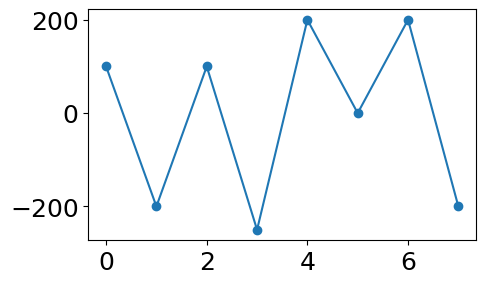

In [3]:
load_sequence = pd.Series([100, -200, 100, -250, 200, 0, 200, -200])  # [N]
fig = plt.figure(figsize=(5,3))
plt.plot(load_sequence, "o-")

### Run FKM nonlinear algorithm

In [4]:
#%%script false --no-raise-error
result = pylife.strength.fkm_nonlinear.assessment_nonlinear_standard\
    .perform_fkm_nonlinear_assessment(assessment_parameters, load_sequence, calculate_P_RAM=True, calculate_P_RAJ=True)

#### Output resulting lifetimes

In [5]:
print("P_RAM")
is_life_infinite = result["P_RAM_is_life_infinite"]
lifetime_n_cycles = result["P_RAM_lifetime_n_cycles"]
lifetime_n_times_load_sequence = result["P_RAM_lifetime_n_times_load_sequence"]
print(f"   Infinite life:                     {is_life_infinite}")
print(f"   Number of bearable cycles:         {lifetime_n_cycles:.0f}")
print(f"   Number of bearable load sequences: {lifetime_n_times_load_sequence:.0f}")

print("")
print("P_RAJ canonical (Miner Elementary)")
is_life_infinite = result["P_RAJ_is_life_infinite"] if "P_RAJ_is_life_infinite" in result else None
lifetime_n_cycles = result["P_RAJ_lifetime_n_cycles"] if "P_RAJ_lifetime_n_cycles" in result else -1
lifetime_n_times_load_sequence = result["P_RAJ_lifetime_n_times_load_sequence"] if "P_RAJ_lifetime_n_times_load_sequence" in result else -1

miner_is_life_infinite = result['P_RAJ_miner_is_life_infinite']

miner_lifetime_n_cycles = result['P_RAJ_miner_lifetime_n_cycles']
miner_lifetime_n_times_load_sequence = result['P_RAJ_miner_lifetime_n_times_load_sequence']
print(f"   Infinite life:                     {is_life_infinite} ({miner_is_life_infinite})")
print(f"   Number of bearable cycles:         {lifetime_n_cycles:.0f} ({miner_lifetime_n_cycles:.0f})")
print(f"   Number of bearable load sequences: {lifetime_n_times_load_sequence:.0f} "
      f"({miner_lifetime_n_times_load_sequence:.0f})")


P_RAM
   Infinite life:                     False
   Number of bearable cycles:         239646
   Number of bearable load sequences: 59911

P_RAJ canonical (Miner Elementary)
   Infinite life:                     False (False)
   Number of bearable cycles:         781480 (505343)
   Number of bearable load sequences: 195370 (126336)


#### Output collective

In [6]:
# The following fields are available in the result:
print(result.keys())
result['P_RAM_recorder_collective']

dict_keys(['extended_neuber_binned', 'P_RAM_damage_parameter', 'P_RAM_is_life_infinite', 'P_RAM_lifetime_n_cycles', 'P_RAM_lifetime_n_times_load_sequence', 'P_RAM_lifetime_N_1ppm', 'P_RAM_lifetime_N_10', 'P_RAM_lifetime_N_50', 'P_RAM_lifetime_N_90', 'P_RAM_N_max_bearable', 'P_RAM_failure_probability', 'P_RAM_recorder_collective', 'P_RAM_collective', 'P_RAM_woehler_curve', 'P_RAM_damage_calculator', 'P_RAM_detector', 'P_RAM_detector_1st', 'seeger_beste_binned', 'P_RAJ_damage_parameter', 'P_RAJ_is_life_infinite', 'P_RAJ_lifetime_n_cycles', 'P_RAJ_lifetime_n_times_load_sequence', 'P_RAJ_miner_damage_calculator', 'P_RAJ_miner_is_life_infinite', 'P_RAJ_miner_lifetime_n_cycles', 'P_RAJ_miner_lifetime_n_times_load_sequence', 'P_RAJ_lifetime_N_1ppm', 'P_RAJ_lifetime_N_10', 'P_RAJ_lifetime_N_50', 'P_RAJ_lifetime_N_90', 'P_RAJ_N_max_bearable', 'P_RAJ_failure_probability', 'P_RAJ_recorder_collective', 'P_RAJ_collective', 'P_RAJ_woehler_curve', 'P_RAJ_damage_calculator', 'P_RAJ_detector', 'P_RAJ_d

,,loads_min,loads_max,S_min,S_max,R,epsilon_min,epsilon_max,S_a,S_m,epsilon_a,epsilon_m,epsilon_min_LF,epsilon_max_LF,is_closed_hysteresis,is_zero_mean_stress_and_strain,run_index,debug_output
hysteresis_index,assessment_point_index,,,,,,,,,,,,,,,,,
0,0,-140.0,140.0,-138.923720,138.923720,-1.000000,-0.000685,0.000685,138.923720,0.000000,0.000685,0.000000,0.000000,0.000685,False,True,1,
1,0,-280.0,140.0,-254.118717,150.149735,-1.692435,-0.001500,0.000619,202.134226,-51.984491,0.001060,-0.000440,-0.001500,0.000685,True,False,1,
2,0,0.0,280.0,-21.326590,256.520851,-0.083138,0.000109,0.001478,138.923720,117.597131,0.000685,0.000793,-0.002023,0.001478,True,False,1,
3,0,-280.0,140.0,-251.716583,152.551869,-1.650039,-0.001521,0.000598,202.134226,-49.582357,0.001060,-0.000462,-0.002023,0.001478,True,False,2,
4,0,-280.0,140.0,-251.716583,152.551869,-1.650039,-0.001521,0.000598,202.134226,-49.582357,0.001060,-0.000462,-0.002023,0.001478,True,False,2,
5,0,-350.0,280.0,-295.009952,256.520851,-1.150043,-0.002023,0.001478,275.765401,-19.244551,0.001751,-0.000272,-0.002023,0.001478,True,False,2,
6,0,0.0,280.0,-21.326590,256.520851,-0.083138,0.000109,0.001478,138.923720,117.597131,0.000685,0.000793,-0.002023,0.001478,True,False,2,


#### Lifetime $N$ for given failure probability $P_A$
The dashed lines show the lifetime if the scaling factor $\gamma_M$ is not clipped at 1.1 (P_RAM), respective 1.2 (P_RAJ).

Text(0, 0.5, 'Lifetime $N$ [-]')

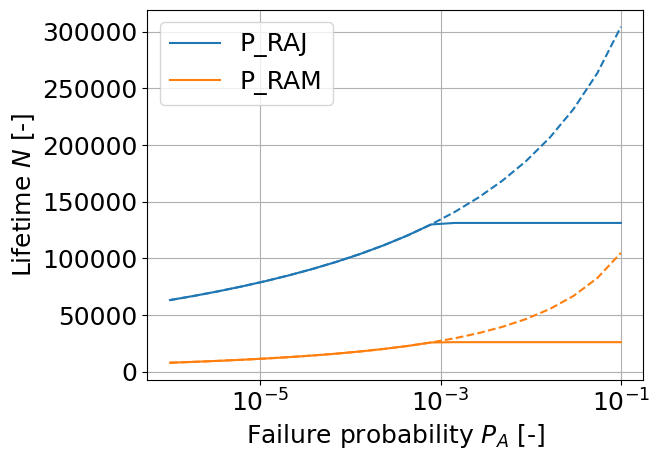

In [7]:
P_RAM_N_max_bearable = result['P_RAM_N_max_bearable']
P_RAJ_N_max_bearable = result['P_RAJ_N_max_bearable']
P_A_list = np.logspace(-6, -1, 20)
p = plt.plot(P_A_list, [P_RAJ_N_max_bearable(P_A,True) for P_A in P_A_list], label="P_RAJ")
p = plt.plot(P_A_list, [P_RAJ_N_max_bearable(P_A) for P_A in P_A_list], "--", color=p[0].get_color())
p = plt.plot(P_A_list, [P_RAM_N_max_bearable(P_A,True) for P_A in P_A_list], label="P_RAM")
p = plt.plot(P_A_list, [P_RAM_N_max_bearable(P_A) for P_A in P_A_list], "--", color=p[0].get_color())
plt.grid(which='both')
plt.legend()
plt.xscale("log")
plt.xlabel("Failure probability $P_A$ [-]")
plt.ylabel("Lifetime $N$ [-]")

#### Plot failure probability
The marked points have $P_A$ = 50%.

Text(0, 0.5, 'Failure probability $P_A$ [-]')

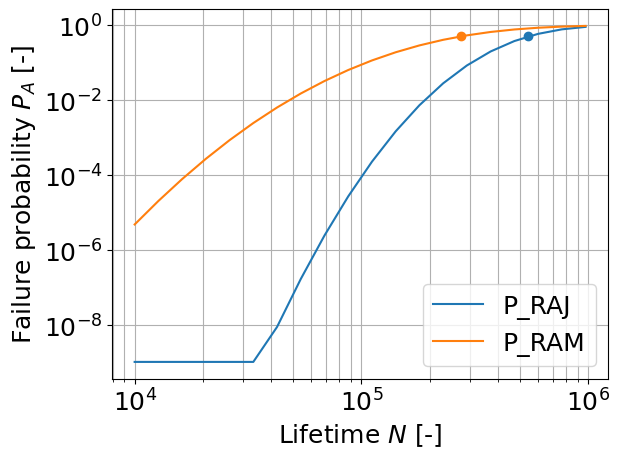

In [8]:
N_list = np.logspace(4, np.log10(result['P_RAJ_lifetime_N_90']), 20)

# P_RAJ
P_RAJ_failure_probability = result['P_RAJ_failure_probability']
p = plt.plot(N_list, [P_RAJ_failure_probability(N) for N in N_list], label="P_RAJ")
plt.plot(result['P_RAJ_lifetime_N_50'], 0.5, "o", color=p[0].get_color())

# P_RAM
P_RAM_failure_probability = result['P_RAM_failure_probability']
p = plt.plot(N_list, [P_RAM_failure_probability(N) for N in N_list], label="P_RAM")
plt.plot(result['P_RAM_lifetime_N_50'], 0.5, "o", color=p[0].get_color())
plt.grid(which='both')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Lifetime $N$ [-]")
plt.ylabel("Failure probability $P_A$ [-]")

#### Woehler curves

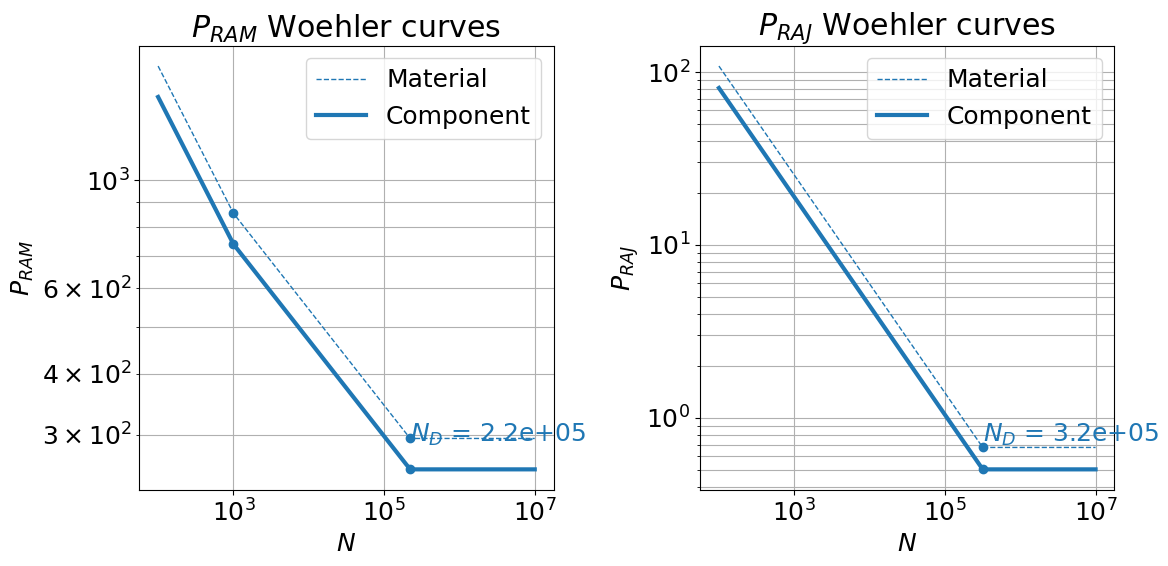

In [9]:
assessment_parameters = result["assessment_parameters"]
component_woehler_curve_P_RAM = result["P_RAM_woehler_curve"]
component_woehler_curve_P_RAJ = result["P_RAJ_woehler_curve"]

# plot component woehler curve P_RAM
n_list = np.logspace(2, 7, num=101, endpoint=True, base=10.0)
plt.rcParams.update({'font.size': 18})
fig,axes = plt.subplots(1,2,figsize=(12,6))

# P_RAM material woehler curve
material_woehler_curve_parameters = assessment_parameters[["P_RAM_Z_WS", "P_RAM_D_WS", "d_1", "d_2"]]
material_woehler_curve_parameters["P_RAM_Z"] = assessment_parameters["P_RAM_Z_WS"]
material_woehler_curve_parameters["P_RAM_D"] = assessment_parameters["P_RAM_D_WS"]

material_woehler_curve_P_RAM = pylife.strength.woehler_fkm_nonlinear\
    .WoehlerCurvePRAM(material_woehler_curve_parameters)

# P_RAJ material woehler curve
material_woehler_curve_parameters = assessment_parameters[["P_RAJ_Z_WS", "P_RAJ_D_WS", "d_RAJ"]]
material_woehler_curve_parameters["P_RAJ_Z"] = assessment_parameters["P_RAJ_Z_WS"]
material_woehler_curve_parameters["P_RAJ_D_0"] = assessment_parameters["P_RAJ_D_WS"]

material_woehler_curve_P_RAJ = pylife.strength.woehler_fkm_nonlinear\
    .WoehlerCurvePRAJ(material_woehler_curve_parameters)

# plot P_RAM material woehler curve
line1 = axes[0].plot(n_list, material_woehler_curve_P_RAM.calc_P_RAM(n_list), "--", lw=1, label="Material")
axes[0].plot(1e3, material_woehler_curve_P_RAM.P_RAM_Z, 
         "o", color=line1[0].get_color())
N_D = material_woehler_curve_P_RAM.fatigue_life_limit
axes[0].plot(N_D, material_woehler_curve_P_RAM.fatigue_strength_limit, 
         "o", color=line1[0].get_color())

# plot P_RAM component woehler curve
line = axes[0].plot(n_list, component_woehler_curve_P_RAM.calc_P_RAM(n_list), "-", lw=3, 
                color=line1[0].get_color(), label="Component")
axes[0].plot(1e3, component_woehler_curve_P_RAM.P_RAM_Z, 
         "o", color=line[0].get_color())
N_D = component_woehler_curve_P_RAM.fatigue_life_limit
axes[0].plot(N_D, component_woehler_curve_P_RAM.fatigue_strength_limit, 
         "o", color=line[0].get_color())
axes[0].annotate(f"$N_D$ = {N_D:.1e}", (N_D, component_woehler_curve_P_RAM.fatigue_strength_limit), 
             textcoords="offset points", xytext=(0,20), color=line[0].get_color())

axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$N$')
axes[0].set_ylabel('$P_{RAM}$')
axes[0].set_title("$P_{RAM}$ Woehler curves")
axes[0].grid(which='both')

# plot P_RAJ material woehler curve
line1 = axes[1].plot(n_list, material_woehler_curve_P_RAJ.calc_P_RAJ(n_list), "--", lw=1, label="Material")
N_D = material_woehler_curve_P_RAJ.fatigue_life_limit
axes[1].plot(N_D, material_woehler_curve_P_RAJ.fatigue_strength_limit, 
         "o", color=line1[0].get_color())

# plot P_RAJ component woehler curve
line = axes[1].plot(n_list, component_woehler_curve_P_RAJ.calc_P_RAJ(n_list), "-", lw=3, 
                color=line1[0].get_color(), label="Component")
N_D = component_woehler_curve_P_RAJ.fatigue_life_limit
axes[1].plot(N_D, component_woehler_curve_P_RAJ.fatigue_strength_limit, 
         "o", color=line[0].get_color())
axes[1].annotate(f"$N_D$ = {N_D:.1e}", (N_D, component_woehler_curve_P_RAJ.fatigue_strength_limit), 
             textcoords="offset points", xytext=(0,20), color=line[0].get_color())

axes[1].legend()
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('$N$')
axes[1].set_ylabel('$P_{RAJ}$')
axes[1].set_title("$P_{RAJ}$ Woehler curves")
axes[1].grid(which='both')
plt.tight_layout()


#### Hystereses

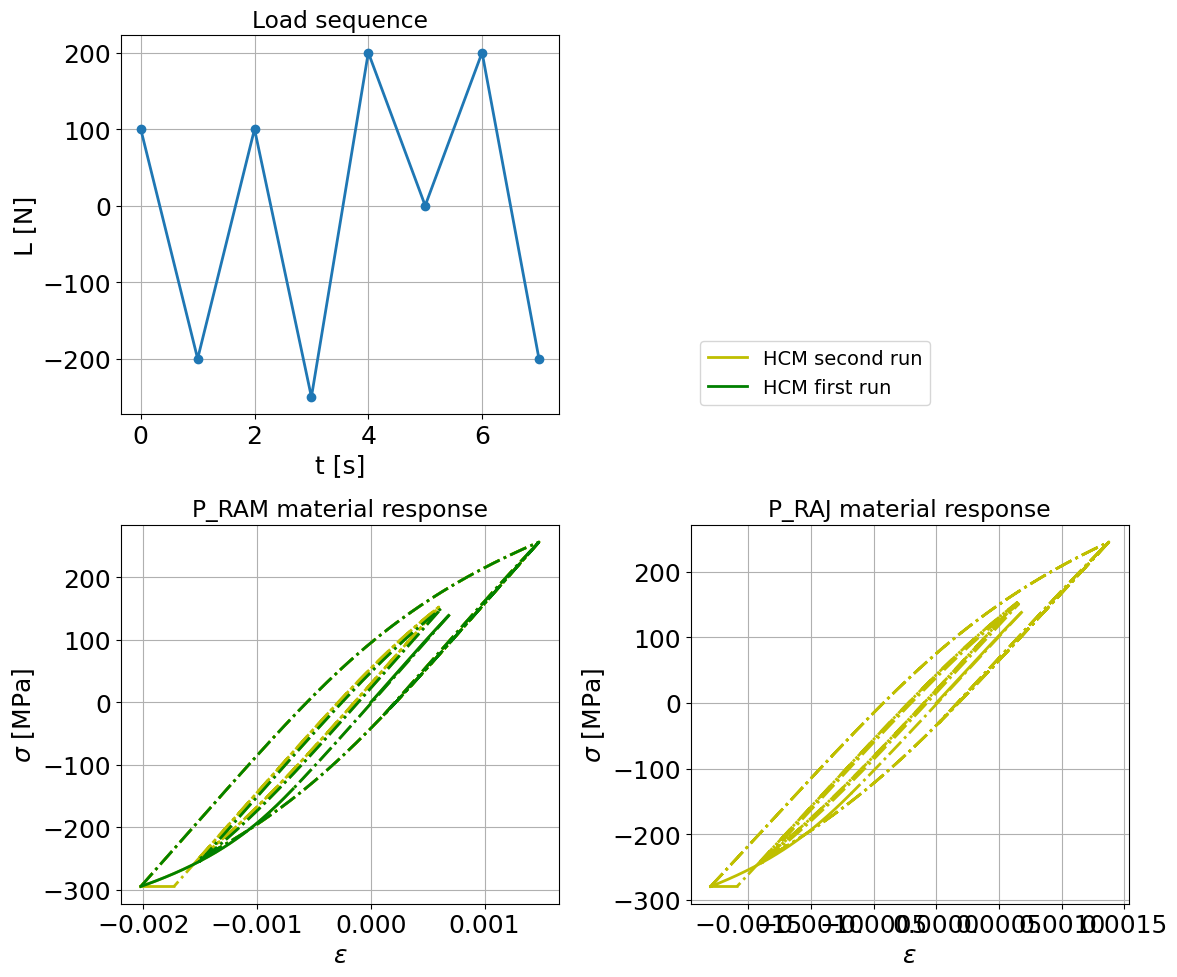

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
    
for i, parameter_name in enumerate(["RAM", "RAJ"]):

    detector = result[f"P_{parameter_name}_detector"]
    detector_1st = result[f"P_{parameter_name}_detector_1st"]

    # plot resulting stress-strain curve
    sampling_parameter = 50    # choose larger for smoother plot
    strain_values_primary, stress_values_primary, hysteresis_index_primary, \
    strain_values_secondary, stress_values_secondary, hysteresis_index_secondary \
        = detector.interpolated_stress_strain_data(sampling_parameter)

    sampling_parameter = 50    # choose larger for smoother plot
    strain_values_primary_1st, stress_values_primary_1st, hysteresis_index_primary_1st, \
    strain_values_secondary_1st, stress_values_secondary_1st, hysteresis_index_secondary_1st \
        = detector_1st.interpolated_stress_strain_data(sampling_parameter)

    # load-time diagram
    if i == 0:
        import matplotlib
        matplotlib.rcParams.update({'font.size': 14})
        axes[0,0].plot(load_sequence, "o-", lw=2)
        axes[0,0].grid()
        axes[0,0].set_xlabel("t [s]")
        axes[0,0].set_ylabel("L [N]")
        axes[0,0].set_title("Load sequence")
    else:
        axes[0,1].axis("off")
        axes[0,1].legend(handles, labels, bbox_to_anchor=(0.0,0), loc='lower left')
        

    # stress-strain diagram
    axes[1,i].plot(strain_values_primary, stress_values_primary, "y-", lw=2, label="HCM second run")
    axes[1,i].plot(strain_values_secondary, stress_values_secondary, "y-.", lw=2)
    axes[1,i].plot(strain_values_primary_1st, stress_values_primary_1st, "g-", lw=2, label="HCM first run")
    axes[1,i].plot(strain_values_secondary_1st, stress_values_secondary_1st, "g-.", lw=2)
    axes[1,i].grid()
    axes[1,i].set_xlabel("$\epsilon$")
    axes[1,i].set_ylabel("$\sigma$ [MPa]")
    axes[1,i].set_title(f"P_{parameter_name} material response")
    handles, labels = axes[1,i].get_legend_handles_labels()
    
plt.tight_layout()

#### Damaging effects of hystereses

Text(0.5, 1.0, 'P_RAJ contribution per hysteresis')

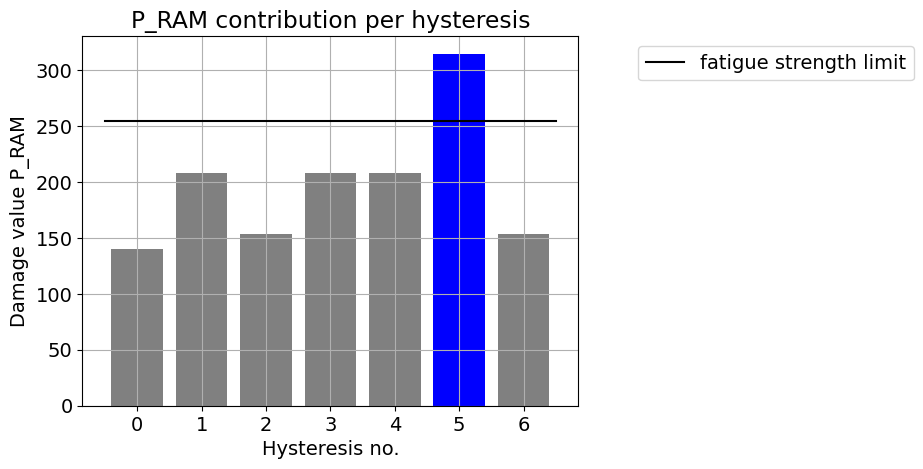

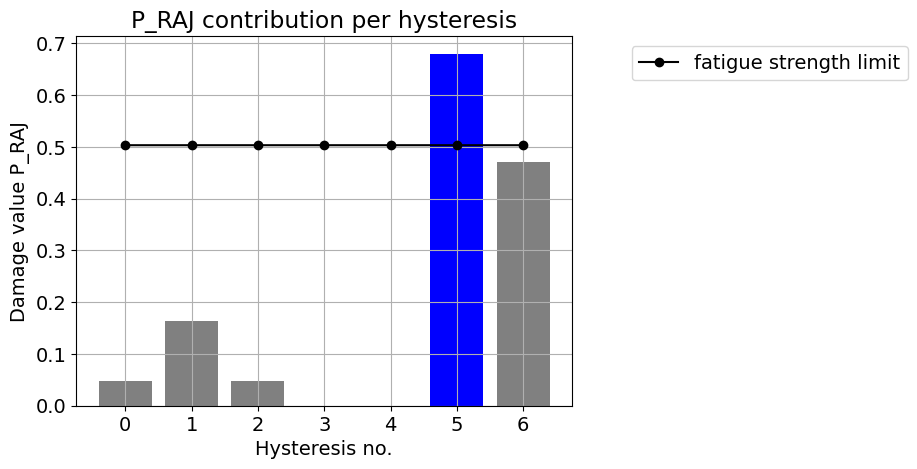

In [11]:
# P_RAM
damage_calculator = result["P_RAM_damage_calculator"]

P_RAM_D = component_woehler_curve_P_RAM.P_RAM_D
plt.figure()
plt.bar(damage_calculator.collective.index.get_level_values("hysteresis_index"), 
        damage_calculator.collective.P_RAM, 
        color=np.where(damage_calculator.collective.P_RAM>P_RAM_D, "b", "gray"))
plt.plot([-0.5,len(damage_calculator.collective)-0.5], [P_RAM_D,P_RAM_D], 
         label="fatigue strength limit", color='k')
plt.legend(bbox_to_anchor=(1.1,1), loc='upper left')
plt.grid()
plt.xlabel("Hysteresis no.")
plt.ylabel("Damage value P_RAM")
plt.title("P_RAM contribution per hysteresis")

# P_RAJ
damage_calculator = result["P_RAJ_damage_calculator"]
P_RAJ_D_last = damage_calculator.collective.P_RAJ_D.values[-1]
hysteresis_index = damage_calculator.collective.index.get_level_values("hysteresis_index")
plt.figure()
plt.bar(hysteresis_index, 
        damage_calculator.collective.P_RAJ, 
        color=np.where(damage_calculator.collective.P_RAJ>damage_calculator.collective.P_RAJ_D, "b", "gray"))
plt.plot(hysteresis_index, damage_calculator.collective.P_RAJ_D, 
         label="fatigue strength limit", color='k', marker="o")
plt.legend(bbox_to_anchor=(1.1,1), loc='upper left')
plt.grid()
plt.xlabel("Hysteresis no.")
plt.ylabel("Damage value P_RAJ")
plt.title("P_RAJ contribution per hysteresis")
